In [104]:

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas
import pandas as pd
from cycler import cycler


plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
#pd.set_option('display.float_format', lambda x: '%0.3e' % x)
pd.set_option('display.float_format', lambda x: '%0.9f' % x)

# Präsentation
## Mirko Matošin und Alexander Wünstel
Lese ein, erstelle statistische Größen

In [105]:
from main import prognose, getsecs

sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
sieb_energien.head()
tmpdf = sieb_energien.join(getsecs(sieb_energien))

Zusammengefasst:

In [106]:
tmpdf.head()
# erstelle Plot-Vektoren

,GesamtEnergie,rectime,ZeigerWinkel
20220509_16_09_32.wav,0.259038925,2022-05-09 16:09:32,ZeigerWinkel.UNSICHER2
20220509_16_09_35.wav,105.340950012,2022-05-09 16:09:35,ZeigerWinkel.RUNTER
20220509_16_09_38.wav,45.166122437,2022-05-09 16:09:38,ZeigerWinkel.RUNTER
20220509_16_09_41.wav,13.809453964,2022-05-09 16:09:41,ZeigerWinkel.RUNTER
20220509_16_09_44.wav,39.506103516,2022-05-09 16:09:44,ZeigerWinkel.RUNTER


In [107]:
tmpdf['GesamtEnergie'].describe()
tmpdf.describe([.01, .5, .99])

,GesamtEnergie
count,18231.000000000
mean,1.411104347
std,7.264719321
min,0.064902961
1%,0.067131209
50%,0.980336726
99%,4.771029615
max,842.714538574


In [108]:
stundenweise = np.arange(0, len(sieb_energien) * 2, 60)
halbstundenweise = np.arange(0, len(sieb_energien) * 2, 30)

Plotte die Grundgesamtheit als Scatter um Ausreisser zu erkennen

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


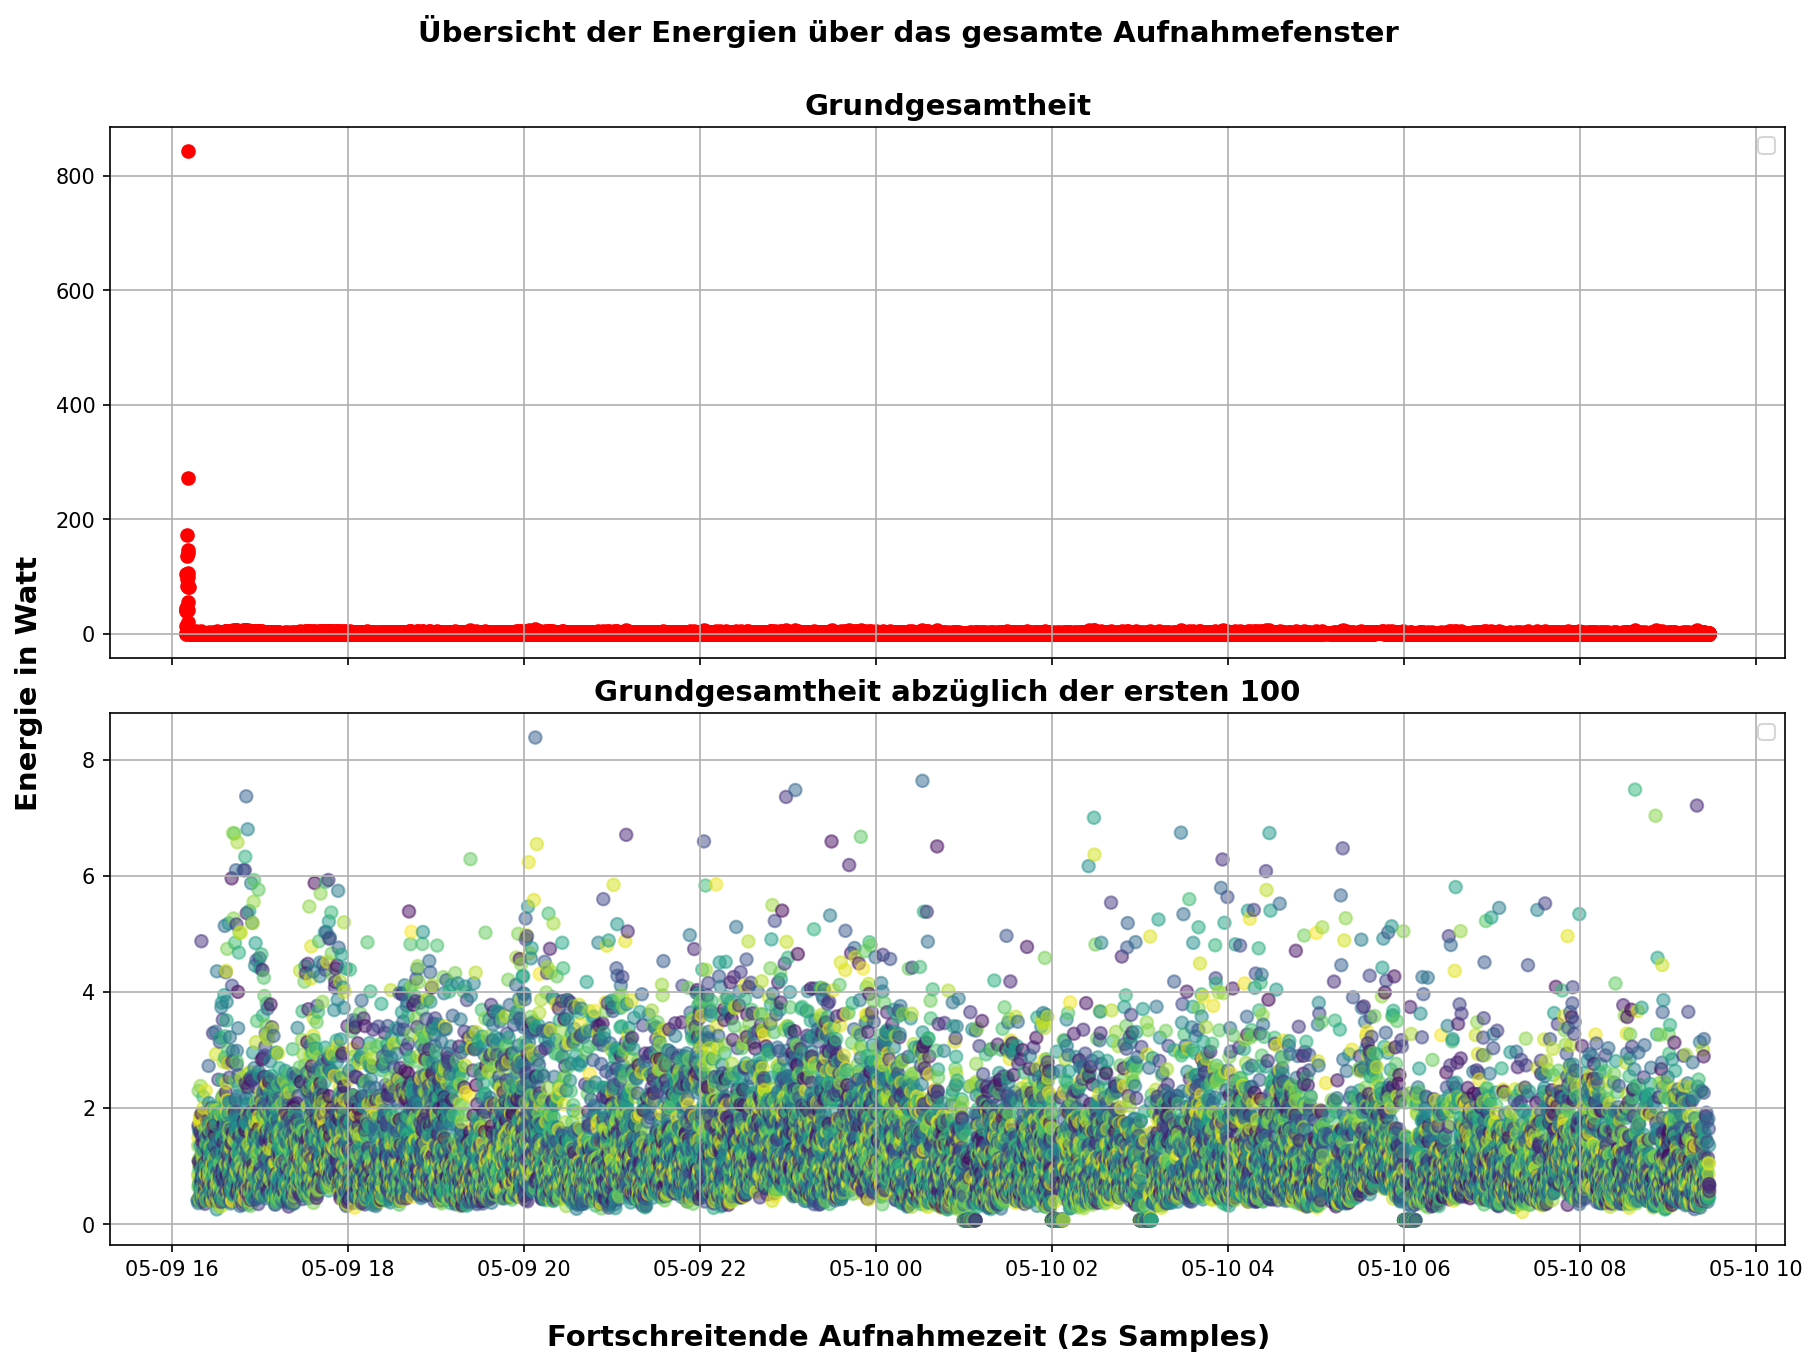

In [109]:
x = pd.to_datetime(tmpdf['rectime'], format='%Y%m%d_%H_%M_%S')
fig, ax = plt.subplots(2, 1, constrained_layout=True, sharex='all')  # , sharey='all')

for i in ax:
    i.grid('True')
    i.legend()

N = 18131
colors = np.random.rand(N)
area = (30 * np.random.rand(N)) ** 2
alpha = np.random.rand(N)

ax[0].scatter(x=x, y=tmpdf['GesamtEnergie'])
ax[1].scatter(x=x[100:], y=tmpdf['GesamtEnergie'][100:], c=colors, alpha=.5)

fig.suptitle('Übersicht der Energien über das gesamte Aufnahmefenster\n', fontsize=14, fontweight='bold')
xlab = '\nFortschreitende Aufnahmezeit (2s Samples)'.format()
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Energie in Watt'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
#ax[0].text(60, .025, r'$\mu=100,\ \sigma=15$')

ax[0].set_title('Grundgesamtheit', fontsize=14, fontweight='bold')
ax[1].set_title('Grundgesamtheit abzüglich der ersten 100', fontsize=14, fontweight='bold')

plt.show()

Man kann eindeutige Ausreisser im oberen Plot sehen. Diese wurden im unteren Plot nicht dargestellt.

## Automatisierte Ausreisser-Erkennung
Im Folgenden soll unsere Herangehensweise erklärt werden. Für die Ausreisser-Erkennung haben wir uns einen einseitigen
Prognosebereich geeinigt. Ziel ist eine Grundgesamtheit minus Ausreisser.

Im ersten Durchlauf haben wir eine t-verteilung angenommen mit einseitigem Verwerfungsbereich.

Für eine erfolgreiche Berechnung und eine vergleichbare Darstellung werden die Energien nun auf 1 normiert.
Hierfür wurde die Annahme getroffen, dass die Bandbreite des Mikrofons $\frac{16\text{ Bit}}{Sample}$ beträgt. Der Pegel kann also von $-2^{15} \text{ bis } 2^{15}$ wandern. Ein Bit muss für das Vorzeichen verwendet werden.

> Bei der Quantisierung wird jede reelle Zahl x(n) der Abtastfolge durch einen Näherungswert aus einer endlichen Menge diskreter Werte ersetzt. Mit anderen Worten, die Quantisierung ist der Prozess der Reduzierung der unendlichen Zahlengenauigkeit eines Audio-Samples auf eine endliche Genauigkeit, die durch eine bestimmte Anzahl von Bits definiert ist. In den meisten Fällen werden 16 Bits pro Sample verwendet, um jedes quantisierte Sample darzustellen, was bedeutet, dass es 2¹⁶ Stufen für das quantisierte Signal gibt. 
> Aus diesem Grund variieren die rohen Audiowerte in der Regel zwischen -2¹⁵ und 2¹⁵ (1 Bit wird für das Vorzeichen verwendet), werden aber, wie wir später sehen werden, der Einfachheit halber in den Bereich (-1, 1) normalisiert. Wir nennen diese Bitauflösungseigenschaft des Quantisierungsverfahrens üblicherweise "Abtastauflösung" und sie wird in Bits pro Abtastung gemessen. [https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y]

Prognosewert: x >=	 13.361439264 W
Prognosewert: x >=	 2.775345176 W
Prognosewert: x >=	 2.047315785 W


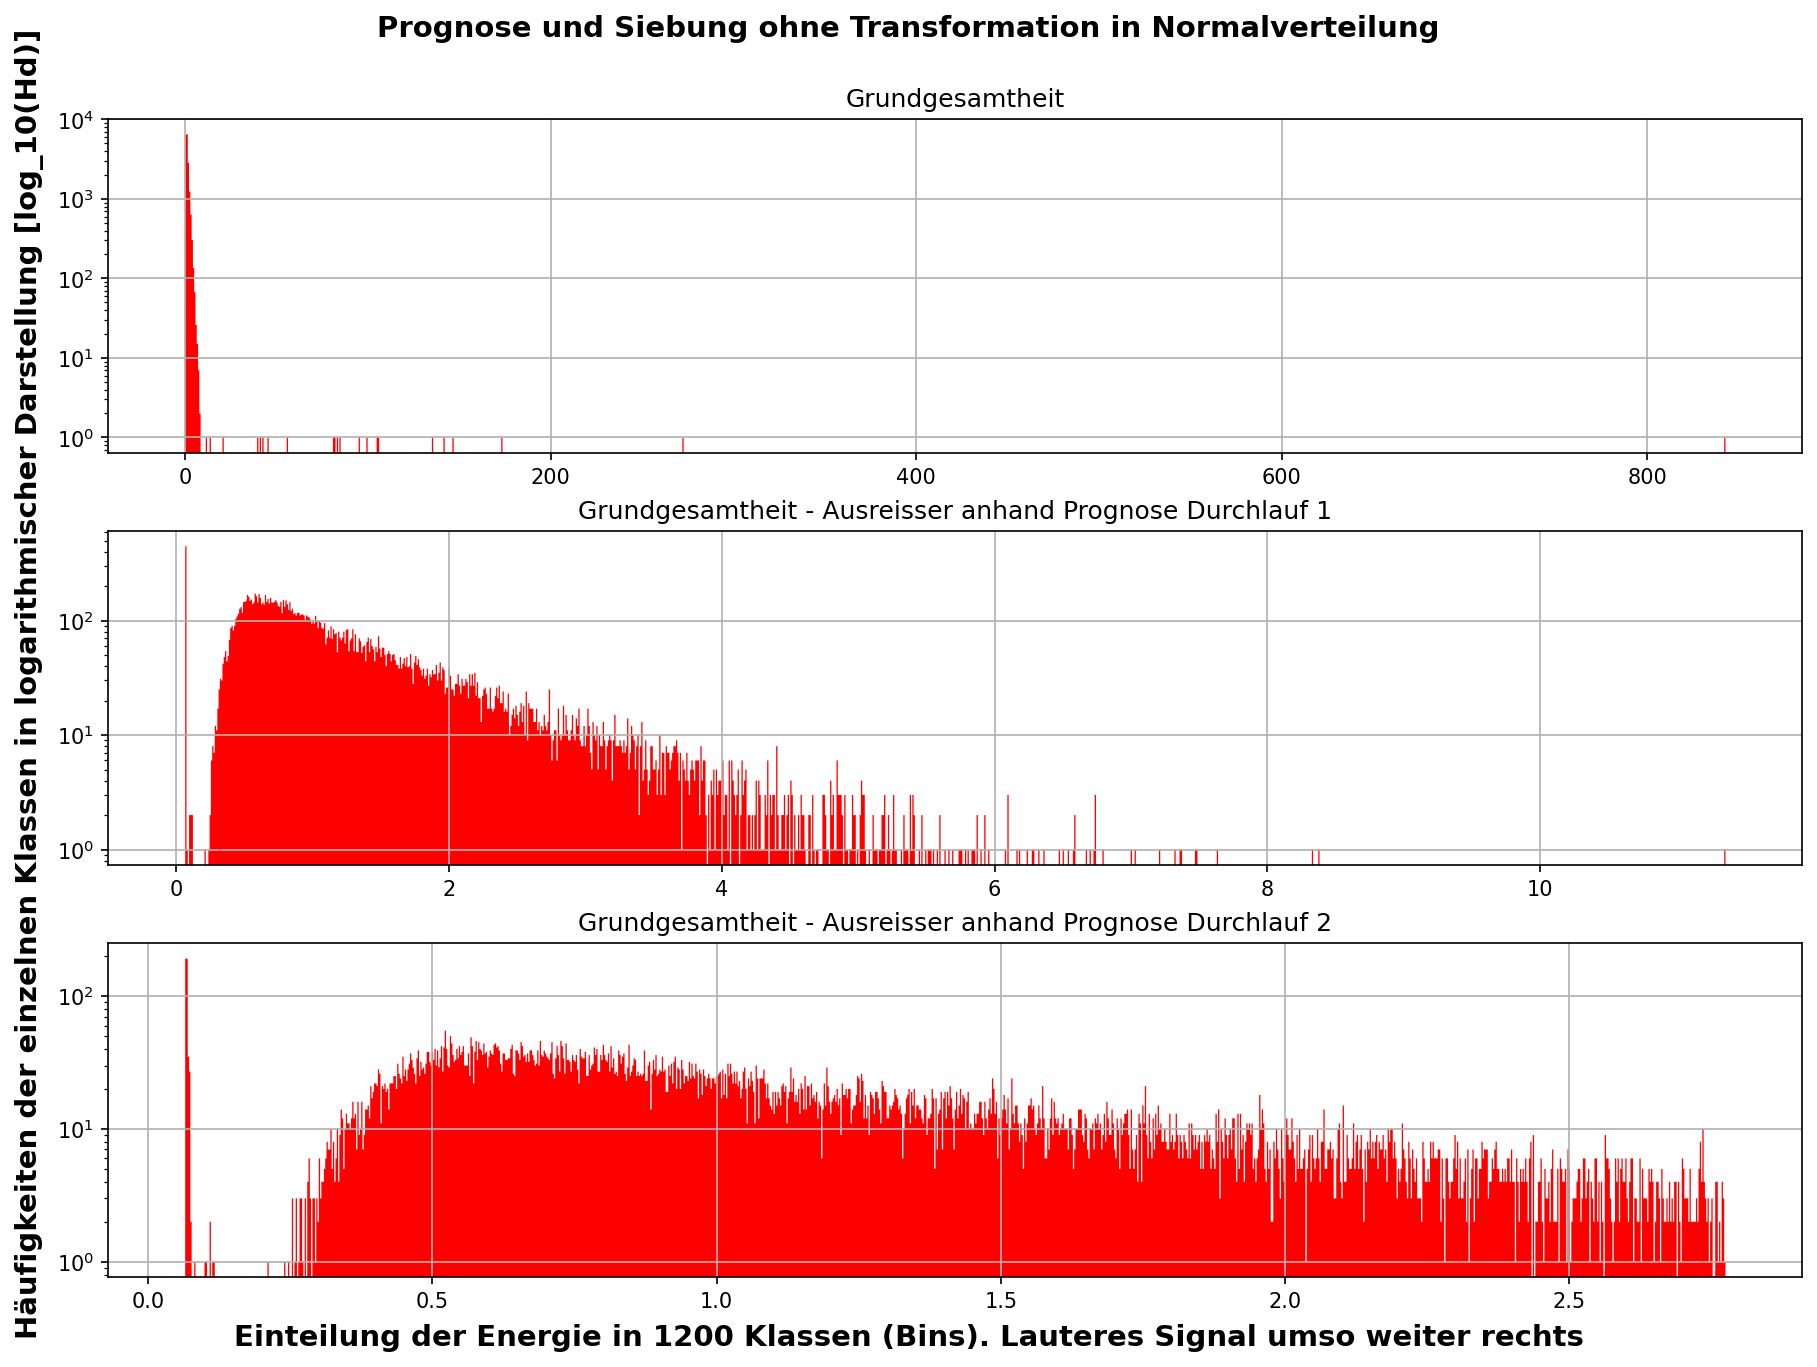

In [110]:
fig, ax = plt.subplots(3, 1, constrained_layout=True)  #, sharex='all')  # , sharey='all')
pwr = sieb_energien['GesamtEnergie'].copy()
mult = 2
n_bins = 1200
for i in ax:
    bins = np.linspace(pwr.min(), pwr.max(), n_bins)  # Create bins of equal size between min_value and max_value

    #pwr[:].hist(bins=bins, grid=True, log=True, ax=ax[0],alpha=0.33*mult)#, density=True, cumulative=True)
    pwr[:].hist(bins=bins, grid=True, log=True, ax=i,histtype='stepfilled')  #, density=True, cumulative=True)
    progmax = prognose(pwr.to_numpy(), gamma=0.95, bereich='rechts')
    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in pwr.index:
        if pwr.loc[x] > progmax:  # or pwr.loc[x] < progmin:
            pwr = pwr.drop(x).copy()
    i.grid('True')

fig.suptitle('Prognose und Siebung ohne Transformation in Normalverteilung\n', fontsize=14, fontweight='bold')
xlab = 'Einteilung der Energie in {} Klassen (Bins). Lauteres Signal umso weiter rechts'.format(n_bins)
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Häufigkeiten der einzelnen Klassen in logarithmischer Darstellung [log_10(Hd)]'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
#ax[0].text(60, .025, r'$\mu=100,\ \sigma=15$')
ax[0].set_title('Grundgesamtheit')
ax[1].set_title('Grundgesamtheit - Ausreisser anhand Prognose Durchlauf 1')
ax[2].set_title('Grundgesamtheit - Ausreisser anhand Prognose Durchlauf 2')
#ax[0].set_ylabel('')
#ax[1].set_ylabel('')
#ax[2].set_ylabel('')
#fig.tight_layout()
plt.show()

Diskussion:
Wir sehen deutlich eine Abgrenzung im leisen Bereich der 3 Plots. Aufgrund des einseitigen Verwerfungsbereich (rechts) lassen sich diese Ausreisser nicht einwandfrei bestimmen. Die t-verteilung ist symmetrisch um den Mittelwert $\mu_0$ verteilt. Auf dem 1. Plot ist bereits keine t-verteilung zu erkennen. 


In [111]:
from IPython.display import Markdown as md

qu = sieb_energien['GesamtEnergie'].quantile(0.01)
anzahl = 0
for x in sieb_energien.index:
    if sieb_energien['GesamtEnergie'].loc[x] > qu:# or pwr.loc[x] < progmin:
        pass
    else:
        anzahl +=1
txt = []
txt.append(('Erfahrungsgemäß ist der untere Schwellenwert:\t{} Watt').format(qu))
txt.append(('Es gibt insgesamt {} Werte die kleiner sind. '+'Daher werden diese Werte vor dem gelöscht').format(anzahl))

qo = sieb_energien['GesamtEnergie'].quantile(0.999)
anzahl = 0
for x in sieb_energien.index:
    if sieb_energien['GesamtEnergie'].loc[x] < qo:# or pwr.loc[x] < progmin:
        pass
    else:
        anzahl +=1

txt.append(('Erfahrungsgemäß ist der obere Schwellenwert:\t{} Watt)').format(qo))
txt.append(('Es gibt insgesamt {} Werte die größer sind. '+'Eine Untersuchung ob diese Daten gelöscht werden, steht noch aus').format(anzahl))
#md(txt)
for i in txt:
    print(i)
    #md(i)


Erfahrungsgemäß ist der untere Schwellenwert:	0.06713120937347405 Watt
Es gibt insgesamt 183 Werte die kleiner sind. Daher werden diese Werte vor dem gelöscht
Erfahrungsgemäß ist der obere Schwellenwert:	35.27932533264963 Watt)
Es gibt insgesamt 19 Werte die größer sind. Eine Untersuchung ob diese Daten gelöscht werden, steht noch aus


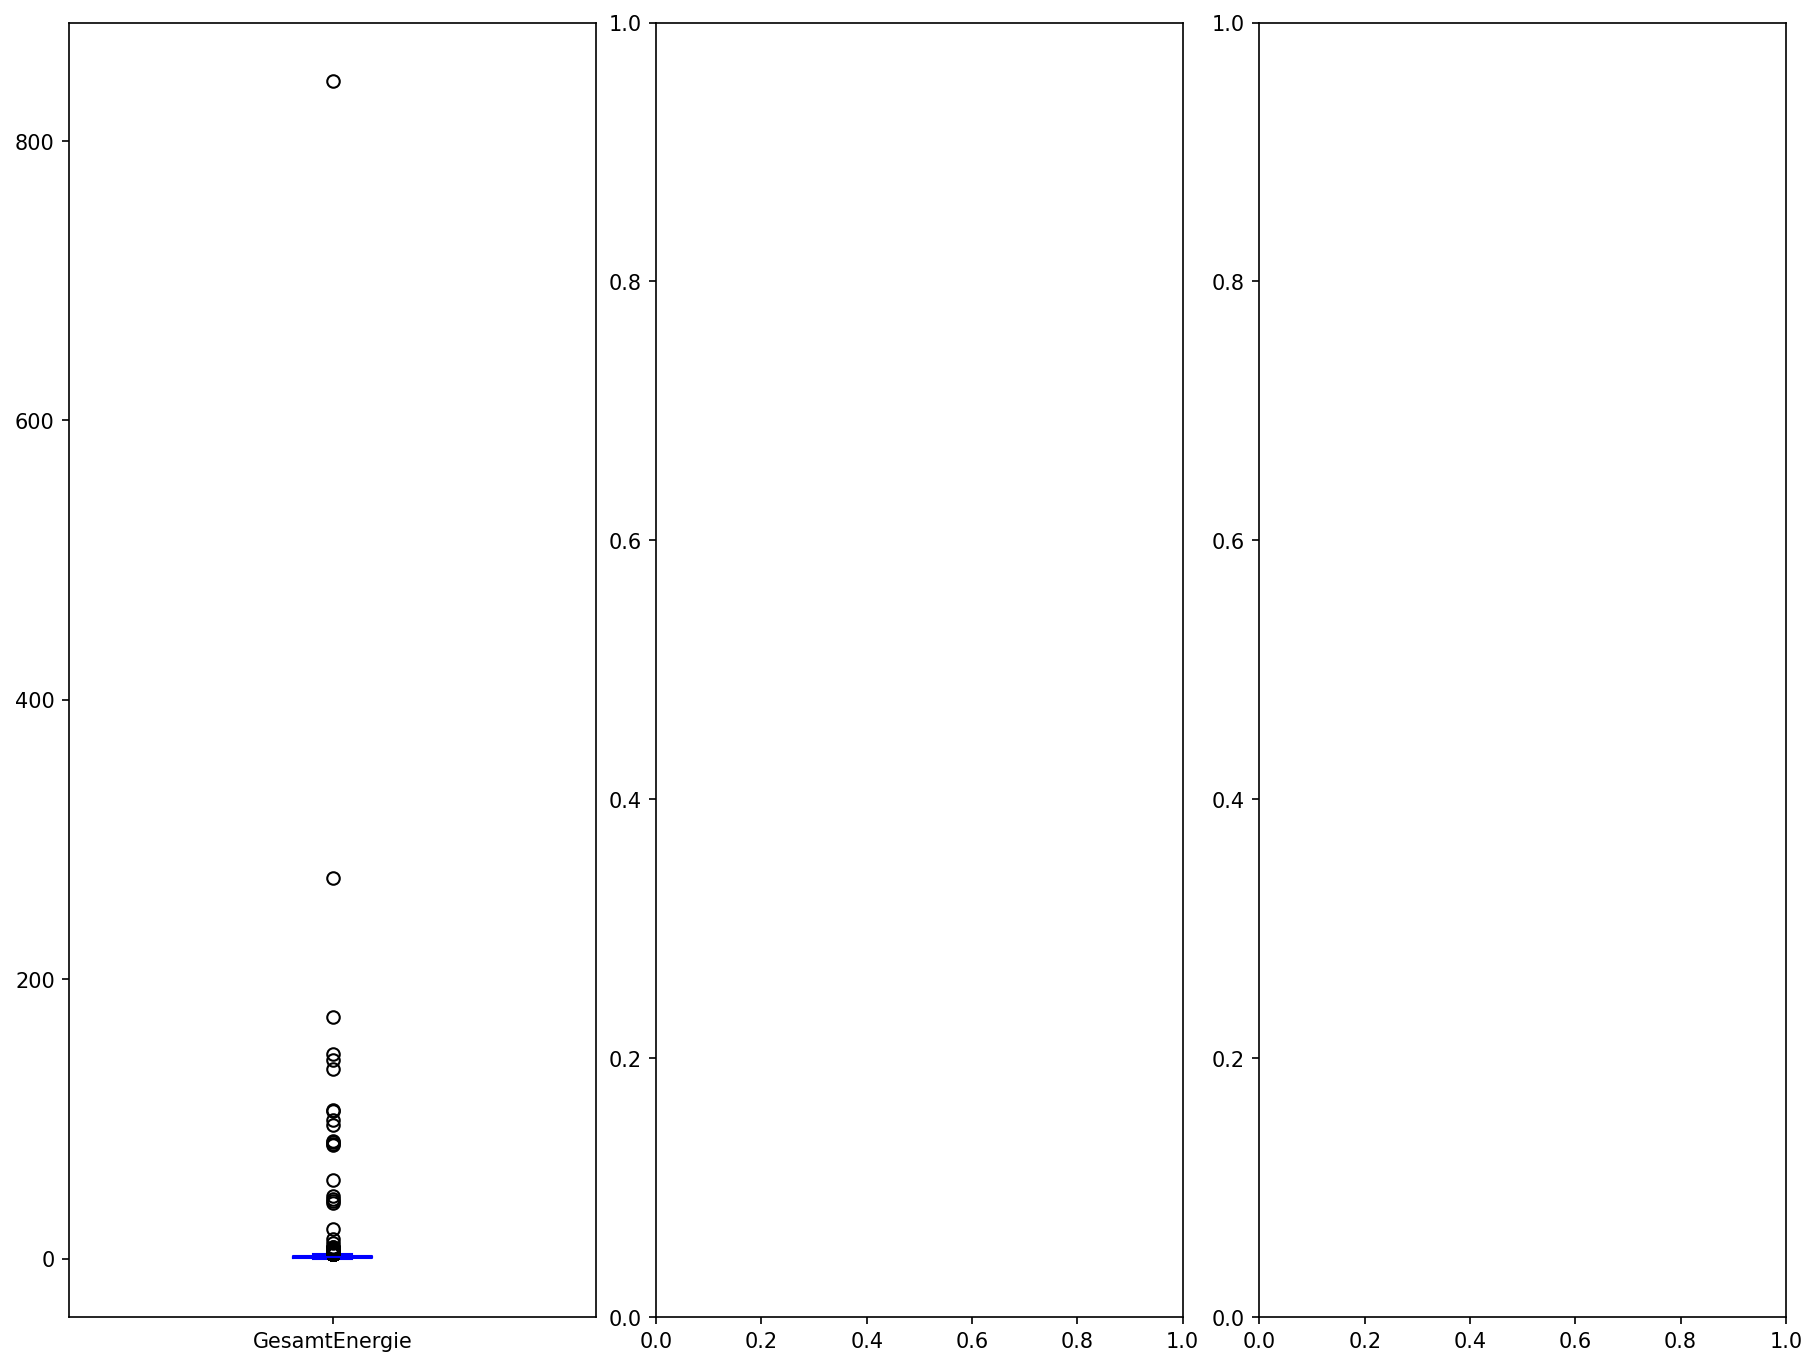

In [112]:
plt.rcParams['figure.dpi'] = 150
# plt.rcParams['interactive'] = True
plt.rcParams['figure.figsize'] = (12, 9)
box, ax = plt.subplots(1,3, constrained_layout=True)
boxplot = sieb_energien.boxplot( grid=False, color='black',ax=ax[0])

Erfahrungsgemäß ist der untere Schwellenwert:	0.06713120937347405 Watt 	(oder Standardisiert:	2.0486819266807268e-06)

Es gibt insgesamt 183 Werte die kleiner sind als 0.06713120937347405 Daher werden diese Werte vor dem gelöscht

Erfahrungsgemäß ist der obere Schwellenwert:	35.27932533264963 Watt 	(oder Standardisiert:	0.0010766395670364266)

Es gibt insgesamt 19 Werte die größer sind als 35.27932533264963 Eine Untersuchung ob diese Daten gelöscht werden, steht noch aus


### Löschen der offensichtlichen Ausreisser aus empirischen Daten

Wir löschen die 183 Datensätze und den einen extremen im oberen Bereich mit 800 mW Leistung



In [151]:
pwr = sieb_energien['GesamtEnergie'].copy() 
print(pwr.shape)
minimalschwellle = pwr.quantile(0.01)  # eigentlich lieber mit der fft für frequenzen kleiner 300 Hz
maximalschwelle = pwr.max()
for x in pwr.index:
    if pwr.loc[x] > minimalschwellle and pwr.loc[x] < maximalschwelle:  # or pwr.loc[x] < progmin:
        pass
    else:
        pwr.drop(x, inplace=True)
print(pwr.shape)
pwr_box = pwr.copy()


(18231,)
(18047,)


Prognosewert: x >=	 7.549183965 W
Prognosewert: x >=	 2.768339482 W
Prognosewert: x >=	 2.045496154 W


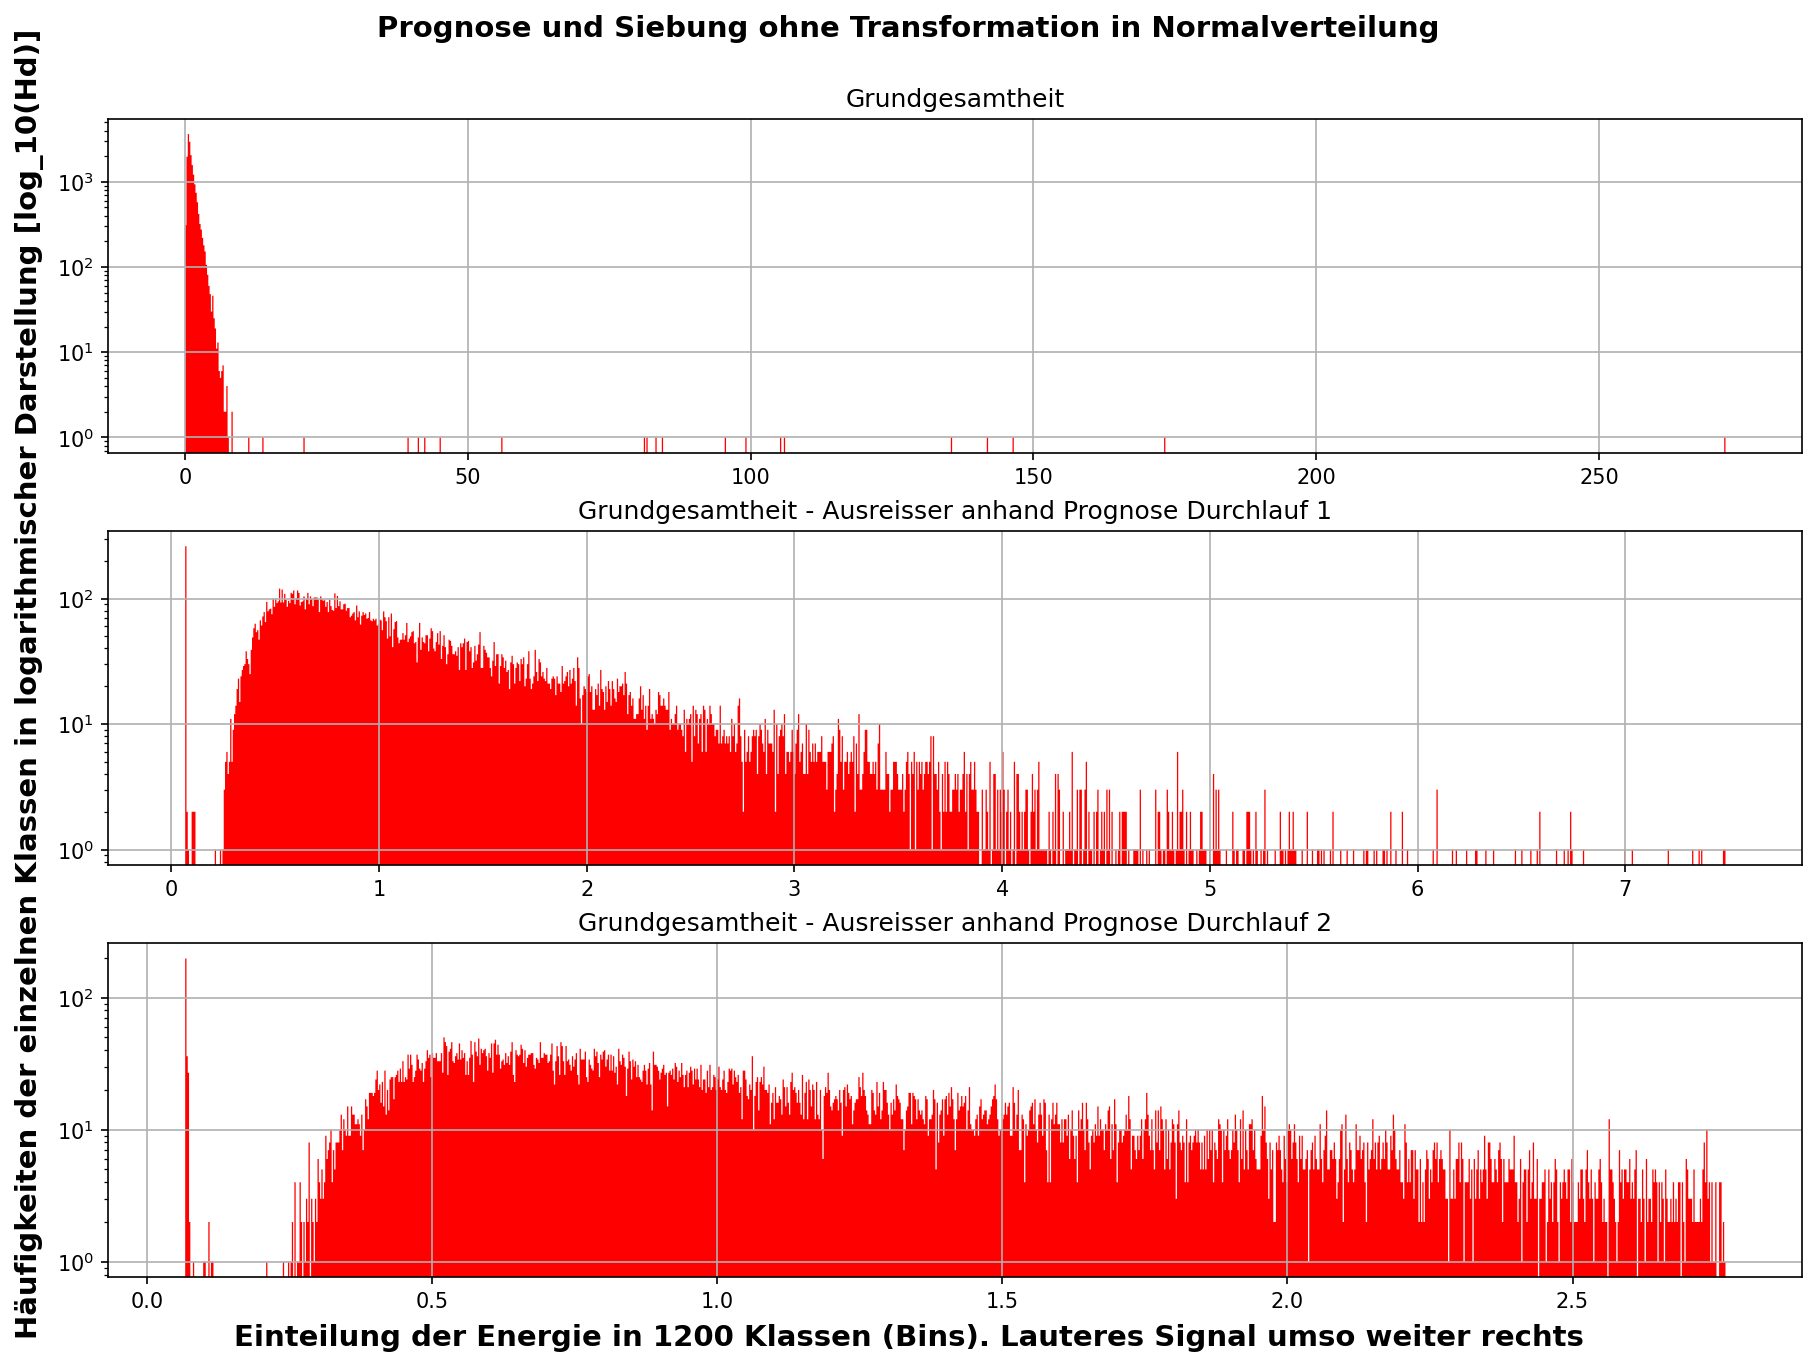

In [114]:
fig, ax = plt.subplots(3, 1, constrained_layout=True)  #, sharex='all')  # , sharey='all')
mult = 2
n_bins = 1200
for i in ax:
    bins = np.linspace(pwr.min(), pwr.max(), n_bins)  # Create bins of equal size between min_value and max_value

    #pwr[:].hist(bins=bins, grid=True, log=True, ax=ax[0],alpha=0.33*mult)#, density=True, cumulative=True)
    pwr[:].hist(bins=bins, grid=True, log=True, ax=i,histtype='stepfilled')  #, density=True, cumulative=True)
    progmax = prognose(pwr.to_numpy(), gamma=0.95, bereich='rechts')
    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in pwr.index:
        if pwr.loc[x] > progmax:  # or pwr.loc[x] < progmin:
            pwr = pwr.drop(x).copy()
    i.grid('True')
    
fig.suptitle('Prognose und Siebung ohne Transformation in Normalverteilung\n', fontsize=14, fontweight='bold')
xlab = 'Einteilung der Energie in {} Klassen (Bins). Lauteres Signal umso weiter rechts'.format(n_bins)
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Häufigkeiten der einzelnen Klassen in logarithmischer Darstellung [log_10(Hd)]'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
#ax[0].text(60, .025, r'$\mu=100,\ \sigma=15$')
ax[0].set_title('Grundgesamtheit')
ax[1].set_title('Grundgesamtheit - Ausreisser anhand Prognose Durchlauf 1')
ax[2].set_title('Grundgesamtheit - Ausreisser anhand Prognose Durchlauf 2')
#ax[0].set_ylabel('')
#ax[1].set_ylabel('')
#ax[2].set_ylabel('')
#fig.tight_layout()
plt.show()

### Diskussion
Die Frage die wir nun stellen 


Nun mit boxcox und stats.probplot

Prognosewert: x >=	 7.549183965 W


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

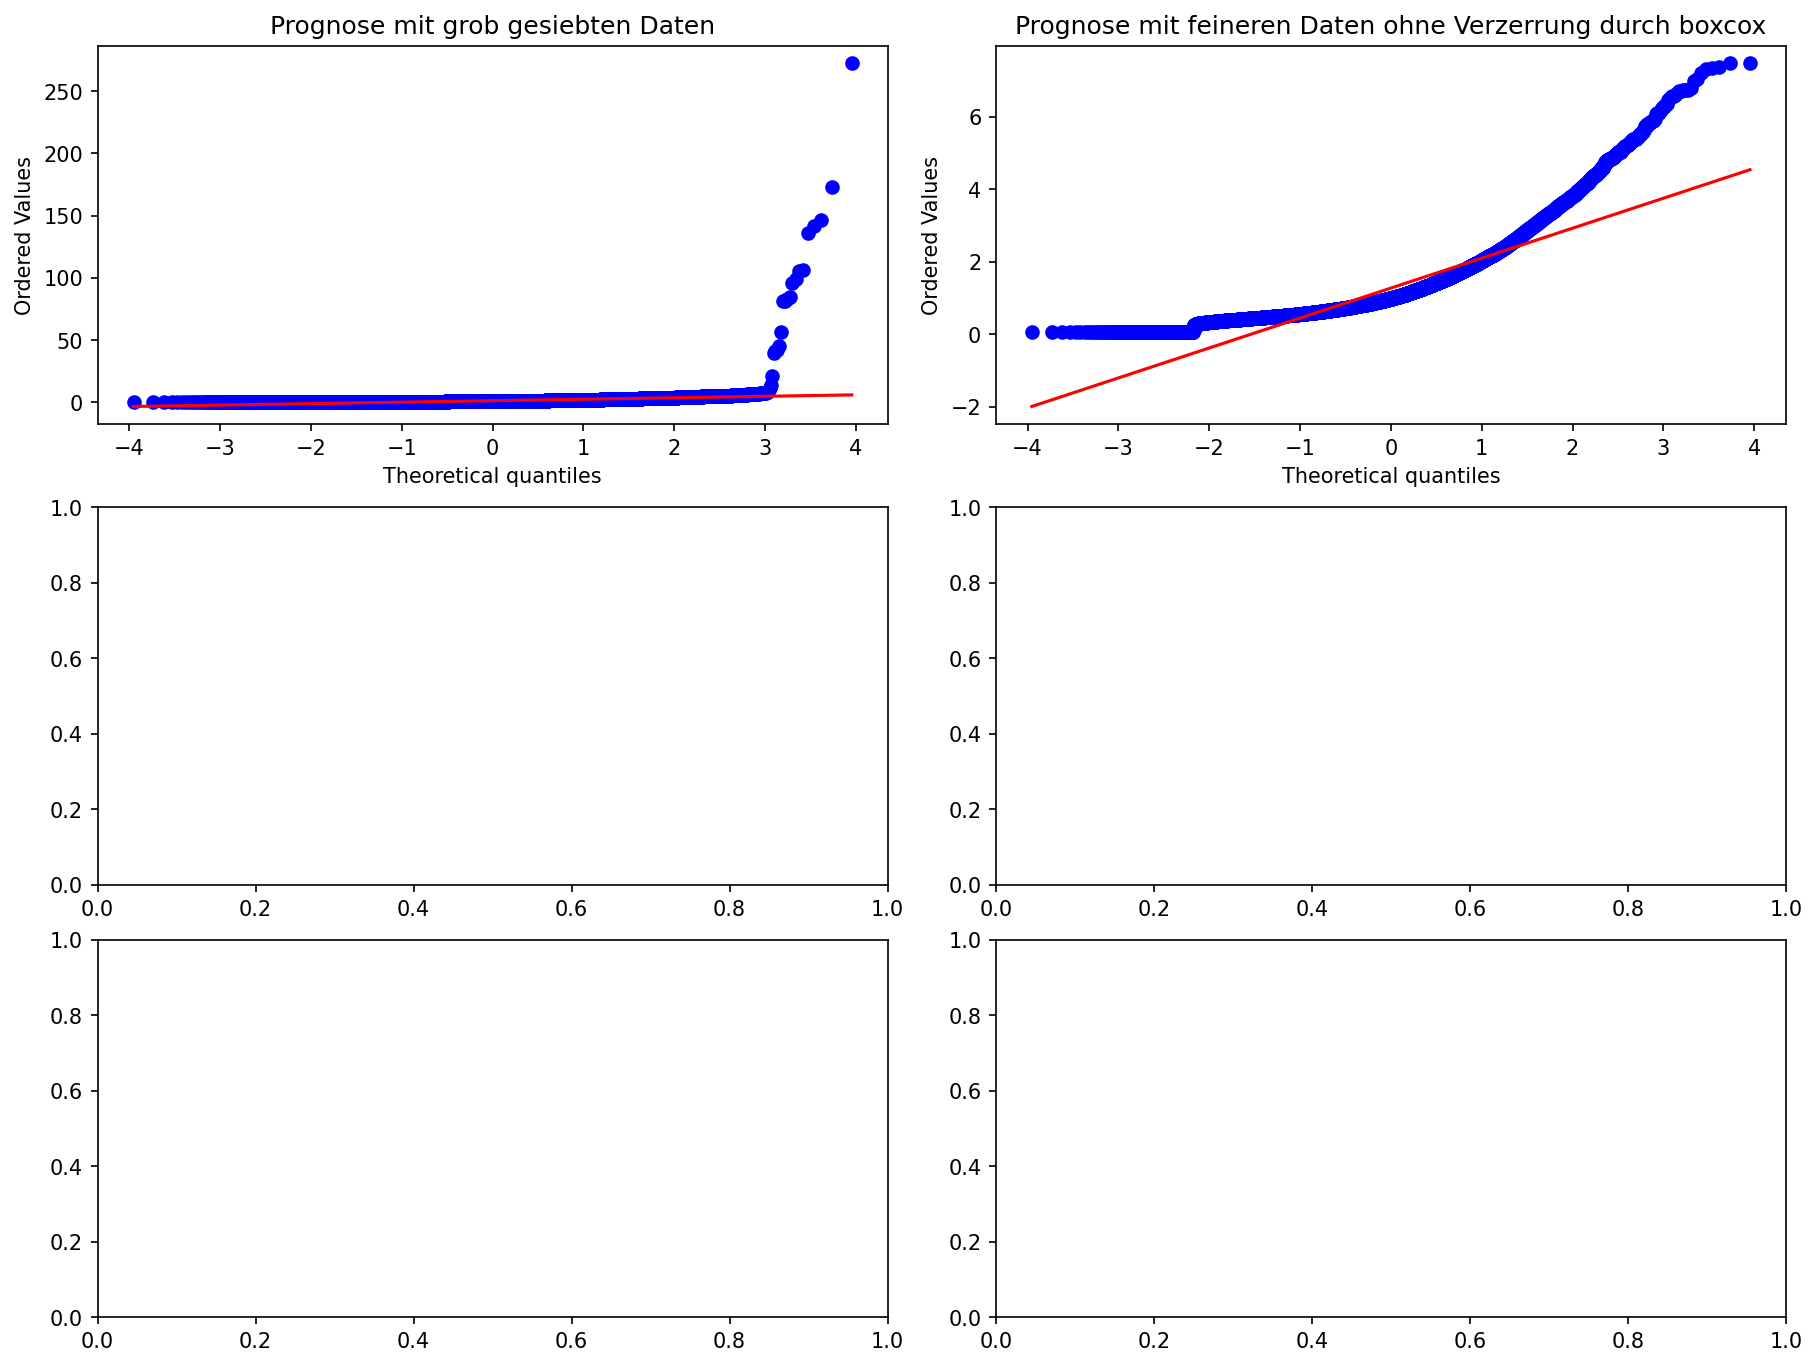

In [152]:
from main import prognose
from scipy import stats
plt.rcParams['figure.dpi'] = 150
# plt.rcParams['interactive'] = True
plt.rcParams['figure.figsize'] = (12, 9)



pwr = sieb_energien['GesamtEnergie'].copy() 
print(pwr.shape)
minimalschwellle = pwr.quantile(0.01)  # eigentlich lieber mit der fft für frequenzen kleiner 300 Hz
maximalschwelle = pwr.max()
for x in pwr.index:
    if pwr.loc[x] > minimalschwellle and pwr.loc[x] < maximalschwelle:  # or pwr.loc[x] < progmin:
        pass
    else:
        pwr.drop(x, inplace=True)
print(pwr.shape)
pwr_box = pwr.copy()


fig, ax = plt.subplots(3, 2, constrained_layout=True)  #, sharex='all')  # , sharey='all')
#ax=ax.ravel()

probpwr = stats.probplot(pwr_box, dist=stats.norm, plot=ax[0,0])
progmax = prognose(pwr_box, gamma=0.95, bereich='rechts')
# siebe nun anhand der prognostizierten Schwellenwerte.
tmppwrbox = pwr_box.copy()
for x in tmppwrbox.index:
    if tmppwrbox.loc[x] > progmax:  # or pwr.loc[x] < progmin:
        tmppwrbox.drop(x, inplace=True)
probpwr = stats.probplot(tmppwrbox, dist=stats.norm, plot=ax[0,1])
ax[0,0].set_title('Prognose mit grob gesiebten Daten')
ax[0,1].set_title('Prognose mit feineren Daten ohne Verzerrung durch boxcox')

ax.ravel()
for i in ax[2:]:

    fitted_data, fitted_lambda = stats.boxcox(pwr_box)
    probfit = stats.probplot(fitted_data, dist=stats.norm, plot=i)
    progmax = prognose(fitted_data, gamma=0.95, bereich='rechts')

    # siebe nun anhand der prognostizierten Schwellenwerte.
    for x in pwr_box.index:
        if pwr_box.loc[x] > progmax:  # or pwr.loc[x] < progmin:
            pwr_box.drop(x, inplace=True)

for i in ax:
    i.grid('True')
    i.legend()


fig.suptitle('Prognose und Siebung mit Transformation in Normalverteilung\n', fontsize=14, fontweight='bold')
#xlab = 'Einteilung der Energie in {} Klassen (Bins)'.format(n_bins)
#fig.supxlabel(xlab, fontsize=14, fontweight='bold')
#ylab = 'Häufigkeiten der einzelnen'.format(n_bins)
#fig.supylabel(ylab, fontsize=14, fontweight='bold')
plt.show()

Nun mit boxcox und hist

Prognosewert: x >=	 -6.291392188 W
(18231,)
(17422,)


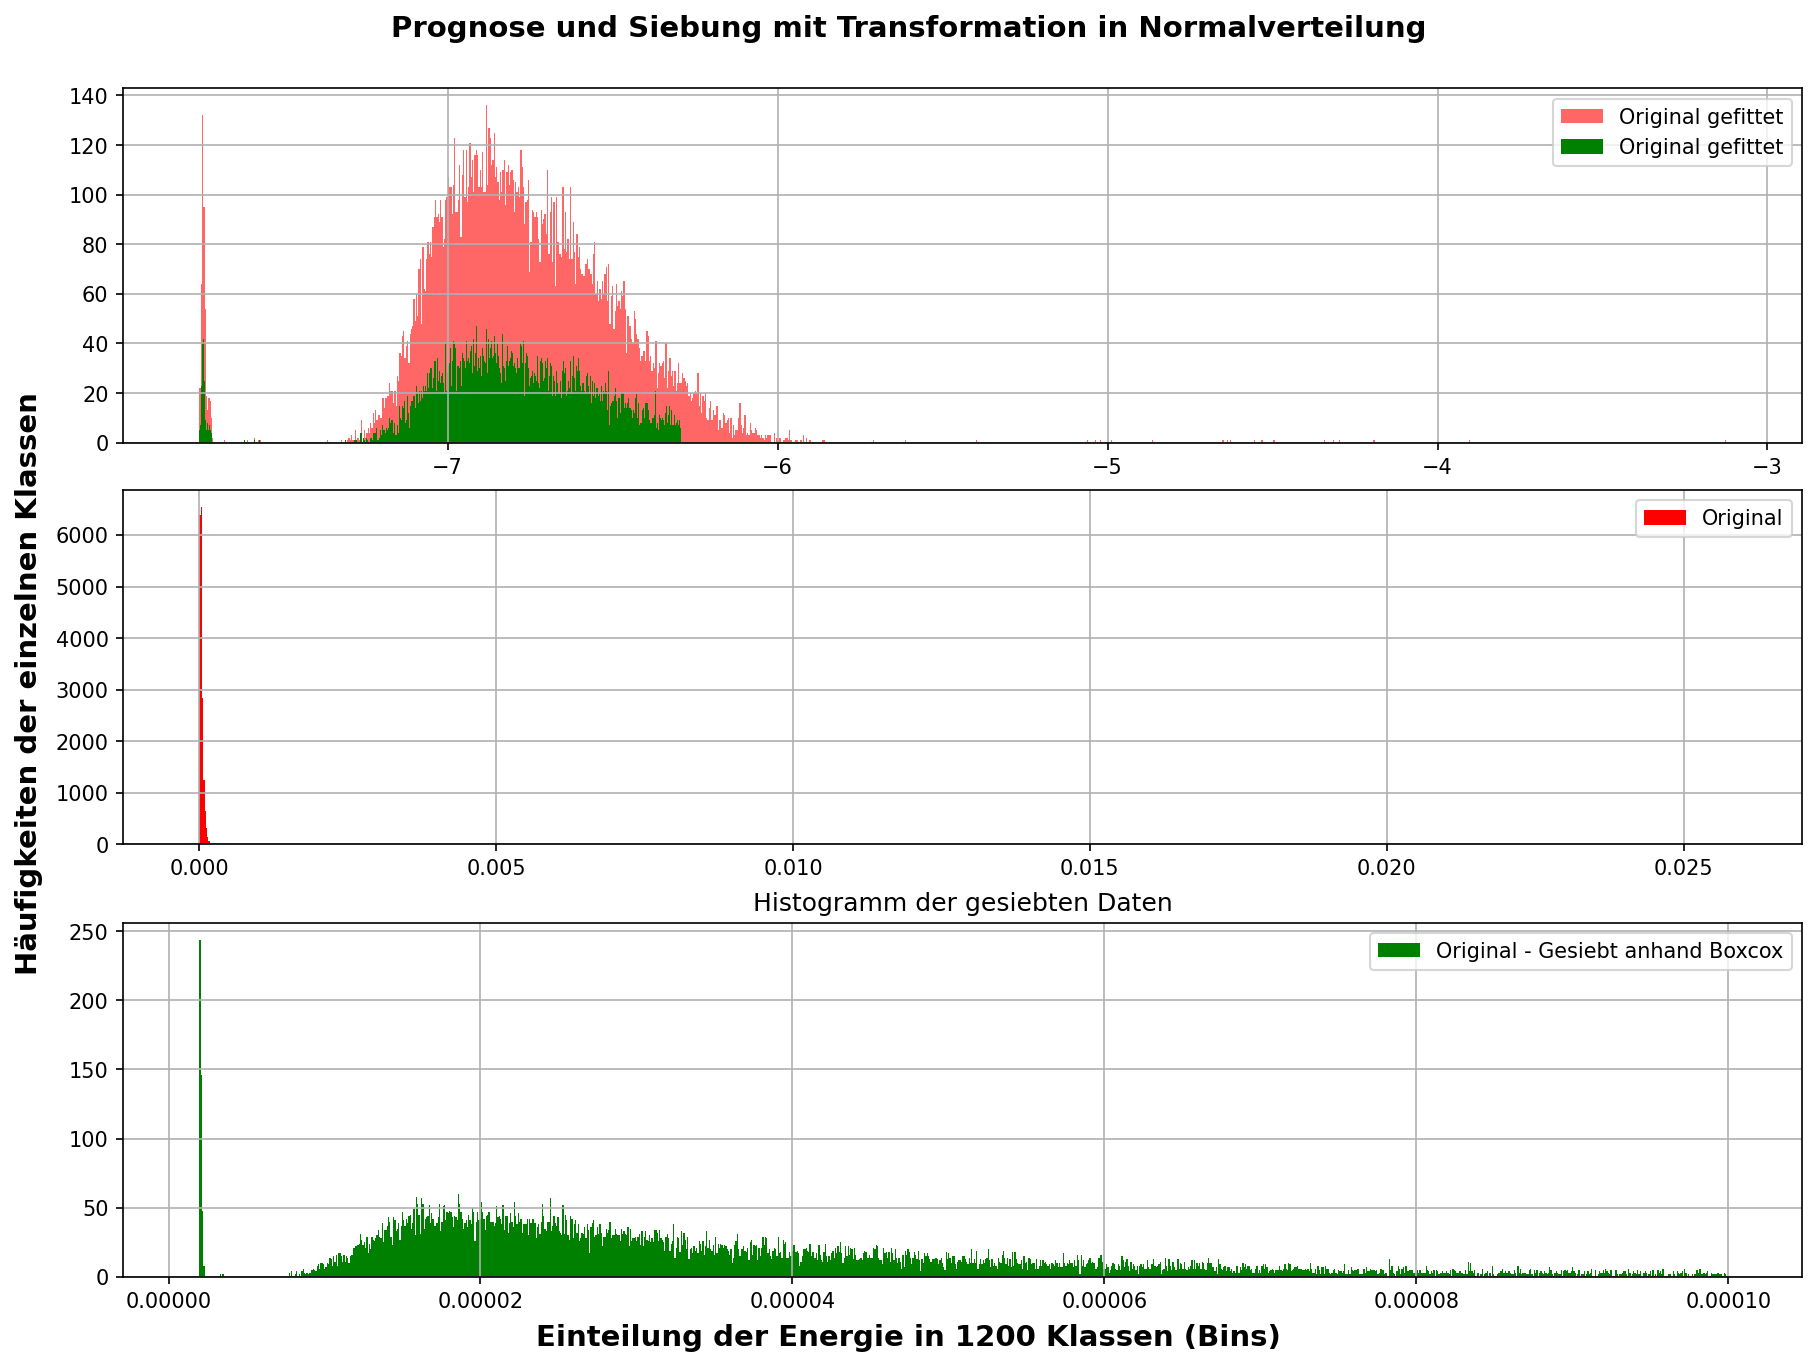

In [116]:
from main import prognose
from scipy import stats

plt.rcParams['figure.dpi'] = 150
# plt.rcParams['interactive'] = True
plt.rcParams['figure.figsize'] = (12, 9)

fig, ax = plt.subplots(3, 1, constrained_layout=True)  #, sharex='all')  # , sharey='all')
#ax=ax.ravel()
mult = 2
n_bins = 1200

sieb_energien = pandas.read_csv('gesamtdaten_energien.csv', index_col=0)
pwr = sieb_energien['GesamtEnergie'].copy() / 2 ** 15
bins = np.linspace(pwr.min(), pwr.max(), n_bins)
pwr[:].hist(bins=bins, grid=True, log=False, ax=ax[1], label='Original')

# Create bins of equal size between min_value and max_value
#for
fitted_data, fitted_lambda = stats.boxcox(pwr)
fitpwr = pandas.Series(fitted_data, index=pwr.index)
bins = np.linspace(fitpwr.min(), fitpwr.max(), n_bins)
i = ax[0]
fitpwr[:].hist(bins=bins, grid=True, log=False, ax=i, label='Original gefittet',
               alpha=0.6)  #, density=True, cumulative=True
# Berechne 1. Schwellenwert
progmax = prognose(fitpwr.to_numpy(), gamma=0.95, bereich='rechts')

for x in fitpwr.index:
    if fitpwr.loc[x] > progmax:  # or pwr.loc[x] < progmin:
        fitpwr = fitpwr.drop(x).copy()

bins = np.linspace(fitpwr.min(), fitpwr.max(), n_bins)
i = ax[0]
fitpwr[:].hist(bins=bins, grid=True, log=False, ax=i, label='Original gefittet')

print(pwr.shape)
fitlist = fitpwr.index.tolist()
for x in pwr.index:
    if x in fitlist:  # or pwr.loc[x] < progmin:
        pass
    else:
        pwr.drop(x, inplace=True)
print(pwr.shape)

bins = np.linspace(pwr.min(), pwr.max(), n_bins)
pwr[:].hist(bins=bins, color='g', grid=True, log=False, ax=ax[2], label='Original - Gesiebt anhand Boxcox')
axs = ax[2]
axs.set_title('Histogramm der gesiebten Daten')

for i in ax:
    i.grid('True')
    i.legend()

fig.suptitle('Prognose und Siebung mit Transformation in Normalverteilung\n', fontsize=14, fontweight='bold')
xlab = 'Einteilung der Energie in {} Klassen (Bins)'.format(n_bins)
fig.supxlabel(xlab, fontsize=14, fontweight='bold')
ylab = 'Häufigkeiten der einzelnen Klassen'
fig.supylabel(ylab, fontsize=14, fontweight='bold')
plt.show()

In [117]:
print(pwr.shape)
fitlist = fitpwr.index.tolist()
for x in pwr.index:
    if x in fitlist:  # or pwr.loc[x] < progmin:
        pass
    else:
        pwr = pwr.drop(x).copy()
print(pwr.shape)

(17422,)
(17422,)


In [118]:
x = ' 20220509_16_09_32.wav'
if x in fitlist:
    print("OK")

OK


In [119]:
print(os.getcwd())

c:\Users\mirko\PycharmProjects\ss22_dfss_clock


In [120]:
#os.chdir("bilder_doku")
#fig.savefig('boxcox.png')
os.chdir(r'C:\Users\mirko\PycharmProjects\ss22_dfss_clock')

In [121]:
a = pwr.nsmallest(10)
print(a)

 20220510_01_00_58.wav   0.000001981
 20220510_01_01_01.wav   0.000001983
 20220510_01_04_14.wav   0.000001984
 20220510_01_05_14.wav   0.000001985
 20220510_06_01_48.wav   0.000001987
 20220510_02_00_58.wav   0.000001991
 20220510_02_00_28.wav   0.000001994
 20220510_02_01_35.wav   0.000001994
 20220510_01_01_51.wav   0.000001994
 20220510_01_04_05.wav   0.000001994
Name: GesamtEnergie, dtype: float64


In [122]:
pd.set_option('display.float_format', lambda x: '%0.3e' % x)

In [123]:
minimalschwellle = pwr.quantile(0.01)  # eigentlich lieber mit der fft für frequenzen kleiner 300 Hz

for x in pwr.index:
    if pwr.loc[x] > minimalschwellle:  # or pwr.loc[x] < progmin:
        pass
    else:
        pwr.drop(x, inplace=True)



In [124]:
pwr.shape




(17247,)